<a href="https://colab.research.google.com/github/DGkurnia/sentiment/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama: Derfansyah Guswiranata Kurnia
* Identitas Dicoding : dgkurnia
* email dicoding : weerakurnia@gmail.com
* Alamat: Jalan Malaka Hijau No 39 Perumahan Malaka Country Estate Jakarta Timur

#Pembaruan

In [83]:
#request dan pandas
!pip install requests pandas

In [84]:
#instalasi sastarawi
!pip install sastrawi

In [85]:
#instalasi wordcloud
!pip install wordcloud

In [86]:
#instalasi backoff
!pip install backoff aiohttp

# Impor Perpustakaan

In [87]:
#untuk akses ke google drive (bila diperlukan)
from google.colab import drive
drive.mount('/content/drive')
#impor file lokal
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
#instalasi perpustakaan
import requests
import json
#Bagian Pandas
import pandas as pd
pd.options.mode.chained_assignment = None #pengaturan peringatan 'rantai'
import csv
import string
#ke manajemen

In [89]:
#manajemen data dasar
import numpy as np
seed = 0 #reprodubilitas
np.random.seed(seed)
#ke plt

In [90]:
#Bagian plt
import matplotlib.pyplot as plt
import datetime as dt #jika ada tanggal
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d
#waktu
import time
#ke sastawi, NLTK, dan wordcloud

In [91]:
#Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #bagian 'stemmer factory'
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [92]:
#sastrawi dan NITK [NITK]
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
from nltk.corpus import stopwords  # Mengimpor modul stopwords dari pustaka NLTK.
from nltk.tokenize import word_tokenize  # Mengimpor fungsi word_tokenize dari modul tokenize dalam pustaka NLTK.

#impor wordcloud
from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
#ke sastrawi

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Impor Teknik

In [93]:
#pemisahan data dengan 'train test split' dan bernouli
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import BernoulliNB

In [94]:
#Teknik untuk inspeksi: perpustakaan untuk klasifikasi
from sklearn.ensemble import RandomForestClassifier as rfclasifi #teknik 'randomfprest'
from sklearn.tree import DecisionTreeClassifier #teknik 'keputusan'
from sklearn.svm import SVC #teknik SVC
from sklearn.linear_model import LogisticRegression

In [95]:
#Bagian re IO bentuk string
import re
from io import StringIO

In [96]:
#metrik penilaian (akurasi, lenyap/loss, nilai f1, nilai recall)
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix as cmatrix, ConfusionMatrixDisplay as cmatdisp, classification_report as clsfrep
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve

In [97]:
#impor seaborn dkk
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
#pelabelan untuk klasifikasi
from sklearn.preprocessing import OneHotEncoder as ohen
from sklearn.preprocessing import LabelBinarizer as labin

#Persiapan Ekstraksi situs

##Pendaftaran situs

In [99]:
#deklarasi 'URL target' dan asal URL
turldoma = 'https://gql.tokopedia.com/graphql/productReviewList'
asal = 'https://www.tokopedia.com' #semua dari Tokopedia
#ke pendaftaran URL

In [100]:
"""
#Daftar 'URL referensi' dan 'cookie' di Tokopedia
#daftar URL referensi
"""
urllist = ["https://www.tokopedia.com/erigo/kemeja-unisex-erigo-short-shirt-jazlyn-black-jazlyn-black-s/review", "https://www.tokopedia.com/erigo/kemeja-unisex-erigo-short-shirt-gribson-rayon-navy-s/review",
"https://www.tokopedia.com/erigo/kemeja-unisex-erigo-short-shirt-lavrenti-white-lavrenti-white-s/review", "https://www.tokopedia.com/erigo/kemeja-unisex-erigo-short-shirt-nessie-dark-green-s/review",
"https://www.tokopedia.com/erigo/kemeja-unisex-erigo-short-shirt-gruney-katun-red-m/review", "https://www.tokopedia.com/erigo/kaos-erigo-t-shirt-oversize-antelope-cotton-combed-black-m/review"]
#ke cookie

In [101]:
#pendaftaran cookie (dari atas ke bawah: a,b,c,d,e,f)
"""
cooklist = ["_UUID_NONLOGIN_=1be9d5e19945cd39ace4288e4df11d97; _UUID_NONLOGIN_.sig=bMaPjt3Ge3Az_etBinByCA2l1rk; _SID_Tokopedia_=DtlRcaR45Ls8u2zR0EyWMaCwIb-lKujUkDrfjGHXD-LOu-8fCzNx6wcE7ORneoiESvjPzMmhkVKp_432p8WHLsvpD-z9xgx1tmq-zHGi5wycyVr7_qPcLfop7H6iXdPJ; DID=c2f41feb0dd15c191936312af3fa4e2422dd2c3bbb9f3e9541c1776d147235161cfabfb1c97d136b51b6dbc495b1e623; DID_JS=YzJmNDFmZWIwZGQxNWMxOTE5MzYzMTJhZjNmYTRlMjQyMmRkMmMzYmJiOWYzZTk1NDFjMTc3NmQxNDcyMzUxNjFjZmFiZmIxYzk3ZDEzNmI1MWI2ZGJjNDk1YjFlNjIz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; _gid=GA1.2.306711698.1737673189; _gcl_au=1.1.1226888024.1737673189; ak_bmsc=F9D6DDE8942BCC4E03713784C42C8052~000000000000000000000000000000~YAAQ5i2pyvOT/5SUAQAANaZklRrhCMh7MdRKtpAkAT/TwhoJpym+giJyrAuJTOGNv+ohla9ReoK+hsgALoV7fD+GGPan21FmvmDA3Jpz1l+G8VPziqy9CfJ5rLLAcar24GlhvuIuN92yOa61cj6XP1wtwpdn2F6mYFZXvbU7QcT0+eqWjBmUDXFDkVs8D1GD5gAjSJD/VDtaRCf0prWFs3kOg16XYNTSegCScJ8Kv8L2UGkEG/B5FhTlwwIu6FzVCQW6M3ZdH3GUGgiUzL5ytrBlQyOvov2YVLwyZwAw37LCLDtbeeHV8RQTdwIHrjrzsz0Fue1Ji3/Wev90Tdl/wVsDzmZP4TISuaW9AcjIMLD3ST2Uc4pA6EulACQadieVuL3tPeZmySNEvZre0qT1ax20YjNqlWsd6eb8I0N3EphQ0QwozUoEbUNJO17X4ba/RRpGoj8tZ7JGCvF+Ga9q; _tt_enable_cookie=1; _ttp=_IQX8m81OgCxhAo11C3x8JEYJOn.tt.1; AMP_TOKEN=%24NOT_FOUND; TOPATK=ReLaxbN0Sma8Hy5pndRT5w; l=1; tuid=39275554; gec_id=168687219962298048; uidh=hQ343xlJhV8WFIBvzr8NcCaECmZcWRGgONmdJbMgjPA=; g_yolo_production=1; _hjSessionUser_714968=eyJpZCI6ImI2NWU2NDJkLWUzNjQtNWJkNS1iYmZlLTEwNmQ0NDFhMGYzMSIsImNyZWF0ZWQiOjE3Mzc2NzMxOTU0OTQsImV4aXN0aW5nIjpmYWxzZX0=; _hjSession_714968=eyJpZCI6ImVkMDdhZTczLTgzZmQtNDJiZS1iN2FlLTU0ZWEzMGVkMWRmMiIsImMiOjE3Mzc2NzMxOTU0OTUsInMiOjEsInIiOjAsInNiIjowLCJzciI6MCwic2UiOjAsImZzIjoxfQ==; FPF=1; uide=5qQ0pbbCxjoGja6Ax6qAQqJlBFCD/TpsLQvYJ5OPxJSbNnPv; _abck=9D01A68AF9735B44B661F7443776CBFC~0~YAAQCOnOF74i9I6UAQAA3fVklQ2RZncTh0GbsOGuOQhk8j87LPzIjovZ0eQzg5ndulVy7y1ZXGxKtJvvUbnmcJojUcEmmxgZLEeB07lgwLRCszxmuNAKrT/My+TBhAwTqXEqvinKZAU/jkBOPmYZZnzCMSAs1b2UM18wmrGUEXFCTtvqlZaNH5SyL5nJr39C8pYVdXQi0zs8gz5LOsxNlrKzpZ3mZiB6lOFDSgsXcZZ26pASD6Sc+FggZmDmrg7xaw5OonWfFs8I2MnhcJl9JnVHC+V5ZRAGsVhpBx8C1+aVQygF2Ran9DVqbI0szhLr++eeFSXbVLVKEnd28i0TeKOi258YEzQ8zUkXnfzXIhdh6SzfQ9SWE9mNoqM2Zza5411V7C+G55fMxN4ch4UapD+wP6RW8i/fbzajbhwZ8L90yOWFIjJNAwlSicNbi1DsLBe/6GMQPUWGSoa6DKFb5YRTVnQDws/iIwhxWtCd2ssOjXRrP/2+E2EEgaLuXvsZwZa7GDhtrhR7sOiYwGaZushVD8mVIS4BNvttUfUbOvFd8+Eumt1loi5KGmF887ayJLy2KXrgw3ZdpR/a7v0uIjdonfr2CRjFIKnanBfrBVTIPMK/K7JcqzzWXrtEpyj/NATBCkDC/kBFxe/xT7aVwzRPODrKV6pmUBmO0SFnJBz/0zKQ3gSzdmxhGQCCE68NhWOVpU0Fa72yDjNafa8=~-1~-1~-1; aus=1; _CASE_=7821624a672139213537363632303b37212f21604a67213932343b2f21674a67213931313a312f216f567367213921313331362e33322e3137573335393333393233283334393333212f216f62772139212e352d3131373433353a212f216f616f2139216e626f62686223606c6d77717a2366707762776623746a7162212f216f6c6d642139213233352d3a3733323436212f2173406c2139213230373533212f21704a67213932323630333634302f2170577a73662139216c6c60212f21744a672139332f21746b70213921585e212f21746b7070213921585e217e; _UUID_CAS_=80e2035b-0ec3-49de-9c32-8100f3d1a615; bm_sz=3CE7B2902701DC0811ED7846832A24AA~YAAQ5i2pyp6n/5SUAQAAbWB1lRozF/IxrbIMwpg86iHC/H7y3/yVRvDgxJibonZ/tuwlVJt0SOyw+VN7SOgqwBayG3Uj9/mPaQQf8YeUoWktS/DJXRUeOQXLNewrTFcqLxKCtpgWMGWx1uGRXNgbyZ11FvsVaQbNWnQ++hW4WoBOPQx15a/snrkNz7W6azb9ekdZNh0RGquEYp7PgQEe2czOQY9NppbVum8H0gV9j/78PDbyMo6JQB4QRv+TBpz16YWULhwO/QiNkJP8w1TLhAcIMT6b/K2La+RHl73HPxSubIKFEdl1bG7IvI7hK208NdsDxYgf5K2/Ll8Djxo/o9ggbJeAj0D6I3FD4ksggJIJxzYM0/1R4Qk8g9OSDKmcjaH1weAspY+vOIj+oDhtxCDqnh6BjErFYPY/gYh5tAOTTfhHtKP+NfT/PWsKdzP/d2ioEqzZfKpZdV1bLyJC0Sa/wKUmxq/rGlFN1to=~3682608~3621682; bm_sv=0087E52D3BACBBB4877168E03A2371D6~YAAQ1i2pyvu2AJWUAQAAzRp4lRpsSK9Kq9IKEENQmF/NP0n81a4G9NW2z1k3l0EdQf8ZoypFgm3B1ftEaI4VqiM6tdlXanArsn4PVjfxjVZ37K08ajCP5hsWmqZnfgkbuPo27GCggtcgw7GC7PFKThXlJkMSawZfzEkjtIFYDoyLOXUoqnbDVarjt7IK99YGIXqrDFPs9DNyn7cqCegduQbkpKQth4SFdyMOJ17gugVxzx1GSsx+QcR1Qtfa9Mcf2mme~1; _dc_gtm_UA-126956641-6=1; _dc_gtm_UA-9801603-1=1; ISID=%7B%22www.tokopedia.com%22%3A%22d3d3LnRva29wZWRpYS5jb20%3D.85807bf8ab475413281ab9e18cc2d094.1737673188674.1737673188674.1737674925795.17%22%2C%22accounts.tokopedia.com%22%3A%22YWNjb3VudHMudG9rb3BlZGlhLmNvbQ%3D%3D.88577841d29294c228b61cfba507abab.1737673195280.1737673195280.1737673208276.1%22%7D; _ga_70947XW48P=GS1.1.1737673188.1.1.1737674925.57.0.0; _ga=GA1.1.108146749.1737673189; webauthn-session=231d1a0a-4caf-4293-8ee5-445a599b6786",
            "_UUID_NONLOGIN_=1be9d5e19945cd39ace4288e4df11d97; _UUID_NONLOGIN_.sig=bMaPjt3Ge3Az_etBinByCA2l1rk; _SID_Tokopedia_=DtlRcaR45Ls8u2zR0EyWMaCwIb-lKujUkDrfjGHXD-LOu-8fCzNx6wcE7ORneoiESvjPzMmhkVKp_432p8WHLsvpD-z9xgx1tmq-zHGi5wycyVr7_qPcLfop7H6iXdPJ; DID=c2f41feb0dd15c191936312af3fa4e2422dd2c3bbb9f3e9541c1776d147235161cfabfb1c97d136b51b6dbc495b1e623; DID_JS=YzJmNDFmZWIwZGQxNWMxOTE5MzYzMTJhZjNmYTRlMjQyMmRkMmMzYmJiOWYzZTk1NDFjMTc3NmQxNDcyMzUxNjFjZmFiZmIxYzk3ZDEzNmI1MWI2ZGJjNDk1YjFlNjIz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; _gid=GA1.2.306711698.1737673189; _gcl_au=1.1.1226888024.1737673189; ak_bmsc=F9D6DDE8942BCC4E03713784C42C8052~000000000000000000000000000000~YAAQ5i2pyvOT/5SUAQAANaZklRrhCMh7MdRKtpAkAT/TwhoJpym+giJyrAuJTOGNv+ohla9ReoK+hsgALoV7fD+GGPan21FmvmDA3Jpz1l+G8VPziqy9CfJ5rLLAcar24GlhvuIuN92yOa61cj6XP1wtwpdn2F6mYFZXvbU7QcT0+eqWjBmUDXFDkVs8D1GD5gAjSJD/VDtaRCf0prWFs3kOg16XYNTSegCScJ8Kv8L2UGkEG/B5FhTlwwIu6FzVCQW6M3ZdH3GUGgiUzL5ytrBlQyOvov2YVLwyZwAw37LCLDtbeeHV8RQTdwIHrjrzsz0Fue1Ji3/Wev90Tdl/wVsDzmZP4TISuaW9AcjIMLD3ST2Uc4pA6EulACQadieVuL3tPeZmySNEvZre0qT1ax20YjNqlWsd6eb8I0N3EphQ0QwozUoEbUNJO17X4ba/RRpGoj8tZ7JGCvF+Ga9q; _tt_enable_cookie=1; _ttp=_IQX8m81OgCxhAo11C3x8JEYJOn.tt.1; AMP_TOKEN=%24NOT_FOUND; TOPATK=ReLaxbN0Sma8Hy5pndRT5w; l=1; tuid=39275554; gec_id=168687219962298048; uidh=hQ343xlJhV8WFIBvzr8NcCaECmZcWRGgONmdJbMgjPA=; g_yolo_production=1; _hjSessionUser_714968=eyJpZCI6ImI2NWU2NDJkLWUzNjQtNWJkNS1iYmZlLTEwNmQ0NDFhMGYzMSIsImNyZWF0ZWQiOjE3Mzc2NzMxOTU0OTQsImV4aXN0aW5nIjpmYWxzZX0=; FPF=1; uide=5qQ0pbbCxjoGja6Ax6qAQqJlBFCD/TpsLQvYJ5OPxJSbNnPv; _abck=9D01A68AF9735B44B661F7443776CBFC~0~YAAQCOnOF74i9I6UAQAA3fVklQ2RZncTh0GbsOGuOQhk8j87LPzIjovZ0eQzg5ndulVy7y1ZXGxKtJvvUbnmcJojUcEmmxgZLEeB07lgwLRCszxmuNAKrT/My+TBhAwTqXEqvinKZAU/jkBOPmYZZnzCMSAs1b2UM18wmrGUEXFCTtvqlZaNH5SyL5nJr39C8pYVdXQi0zs8gz5LOsxNlrKzpZ3mZiB6lOFDSgsXcZZ26pASD6Sc+FggZmDmrg7xaw5OonWfFs8I2MnhcJl9JnVHC+V5ZRAGsVhpBx8C1+aVQygF2Ran9DVqbI0szhLr++eeFSXbVLVKEnd28i0TeKOi258YEzQ8zUkXnfzXIhdh6SzfQ9SWE9mNoqM2Zza5411V7C+G55fMxN4ch4UapD+wP6RW8i/fbzajbhwZ8L90yOWFIjJNAwlSicNbi1DsLBe/6GMQPUWGSoa6DKFb5YRTVnQDws/iIwhxWtCd2ssOjXRrP/2+E2EEgaLuXvsZwZa7GDhtrhR7sOiYwGaZushVD8mVIS4BNvttUfUbOvFd8+Eumt1loi5KGmF887ayJLy2KXrgw3ZdpR/a7v0uIjdonfr2CRjFIKnanBfrBVTIPMK/K7JcqzzWXrtEpyj/NATBCkDC/kBFxe/xT7aVwzRPODrKV6pmUBmO0SFnJBz/0zKQ3gSzdmxhGQCCE68NhWOVpU0Fa72yDjNafa8=~-1~-1~-1; aus=1; _CASE_=7821624a672139213537363632303b37212f21604a67213932343b2f21674a67213931313a312f216f567367213921313331362e33322e3137573335393333393233283334393333212f216f62772139212e352d3131373433353a212f216f616f2139216e626f62686223606c6d77717a2366707762776623746a7162212f216f6c6d642139213233352d3a3733323436212f2173406c2139213230373533212f21704a67213932323630333634302f2170577a73662139216c6c60212f21744a672139332f21746b70213921585e212f21746b7070213921585e217e; _UUID_CAS_=80e2035b-0ec3-49de-9c32-8100f3d1a615; bm_sz=3CE7B2902701DC0811ED7846832A24AA~YAAQ5i2pyp6n/5SUAQAAbWB1lRozF/IxrbIMwpg86iHC/H7y3/yVRvDgxJibonZ/tuwlVJt0SOyw+VN7SOgqwBayG3Uj9/mPaQQf8YeUoWktS/DJXRUeOQXLNewrTFcqLxKCtpgWMGWx1uGRXNgbyZ11FvsVaQbNWnQ++hW4WoBOPQx15a/snrkNz7W6azb9ekdZNh0RGquEYp7PgQEe2czOQY9NppbVum8H0gV9j/78PDbyMo6JQB4QRv+TBpz16YWULhwO/QiNkJP8w1TLhAcIMT6b/K2La+RHl73HPxSubIKFEdl1bG7IvI7hK208NdsDxYgf5K2/Ll8Djxo/o9ggbJeAj0D6I3FD4ksggJIJxzYM0/1R4Qk8g9OSDKmcjaH1weAspY+vOIj+oDhtxCDqnh6BjErFYPY/gYh5tAOTTfhHtKP+NfT/PWsKdzP/d2ioEqzZfKpZdV1bLyJC0Sa/wKUmxq/rGlFN1to=~3682608~3621682; _dc_gtm_UA-126956641-6=1; _dc_gtm_UA-9801603-1=1; bm_sv=0087E52D3BACBBB4877168E03A2371D6~YAAQ1i2pyjjOAJWUAQAAtGaAlRpbTEBP9/HiKaOsYGziDZVk9jU6zEqoEoWY+MZYyAYSDo4mqT5sAxyJ21PWDFu8Mr1AUp+ISb/kJ2/4XVKxu2h9jxp79rj2Do4zGKQLJTOddP4KyIsjj3MsmAAgT5rJfAH0EwEBita1VzOs+Wnf72V27hw6ijN2PPIvZ+uiWklUBeoTIG84ZdY0n/Ez/JM59vEsSKHXG8N8RBWpKzcaEoZSuZZXXlZGA1FPpBC3dEnC~1; ISID=%7B%22www.tokopedia.com%22%3A%22d3d3LnRva29wZWRpYS5jb20%3D.85807bf8ab475413281ab9e18cc2d094.1737673188674.1737673188674.1737675011304.19%22%2C%22accounts.tokopedia.com%22%3A%22YWNjb3VudHMudG9rb3BlZGlhLmNvbQ%3D%3D.88577841d29294c228b61cfba507abab.1737673195280.1737673195280.1737673208276.1%22%7D; _ga_70947XW48P=GS1.1.1737673188.1.1.1737675011.55.0.0; _ga=GA1.1.108146749.1737673189; webauthn-session=b6a6fad4-1d28-40d4-a059-e96aeb37c794",
            "_UUID_NONLOGIN_=1be9d5e19945cd39ace4288e4df11d97; _UUID_NONLOGIN_.sig=bMaPjt3Ge3Az_etBinByCA2l1rk; _SID_Tokopedia_=DtlRcaR45Ls8u2zR0EyWMaCwIb-lKujUkDrfjGHXD-LOu-8fCzNx6wcE7ORneoiESvjPzMmhkVKp_432p8WHLsvpD-z9xgx1tmq-zHGi5wycyVr7_qPcLfop7H6iXdPJ; DID=c2f41feb0dd15c191936312af3fa4e2422dd2c3bbb9f3e9541c1776d147235161cfabfb1c97d136b51b6dbc495b1e623; DID_JS=YzJmNDFmZWIwZGQxNWMxOTE5MzYzMTJhZjNmYTRlMjQyMmRkMmMzYmJiOWYzZTk1NDFjMTc3NmQxNDcyMzUxNjFjZmFiZmIxYzk3ZDEzNmI1MWI2ZGJjNDk1YjFlNjIz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; _gid=GA1.2.306711698.1737673189; _gcl_au=1.1.1226888024.1737673189; ak_bmsc=F9D6DDE8942BCC4E03713784C42C8052~000000000000000000000000000000~YAAQ5i2pyvOT/5SUAQAANaZklRrhCMh7MdRKtpAkAT/TwhoJpym+giJyrAuJTOGNv+ohla9ReoK+hsgALoV7fD+GGPan21FmvmDA3Jpz1l+G8VPziqy9CfJ5rLLAcar24GlhvuIuN92yOa61cj6XP1wtwpdn2F6mYFZXvbU7QcT0+eqWjBmUDXFDkVs8D1GD5gAjSJD/VDtaRCf0prWFs3kOg16XYNTSegCScJ8Kv8L2UGkEG/B5FhTlwwIu6FzVCQW6M3ZdH3GUGgiUzL5ytrBlQyOvov2YVLwyZwAw37LCLDtbeeHV8RQTdwIHrjrzsz0Fue1Ji3/Wev90Tdl/wVsDzmZP4TISuaW9AcjIMLD3ST2Uc4pA6EulACQadieVuL3tPeZmySNEvZre0qT1ax20YjNqlWsd6eb8I0N3EphQ0QwozUoEbUNJO17X4ba/RRpGoj8tZ7JGCvF+Ga9q; _tt_enable_cookie=1; _ttp=_IQX8m81OgCxhAo11C3x8JEYJOn.tt.1; AMP_TOKEN=%24NOT_FOUND; TOPATK=ReLaxbN0Sma8Hy5pndRT5w; l=1; tuid=39275554; gec_id=168687219962298048; uidh=hQ343xlJhV8WFIBvzr8NcCaECmZcWRGgONmdJbMgjPA=; g_yolo_production=1; _hjSessionUser_714968=eyJpZCI6ImI2NWU2NDJkLWUzNjQtNWJkNS1iYmZlLTEwNmQ0NDFhMGYzMSIsImNyZWF0ZWQiOjE3Mzc2NzMxOTU0OTQsImV4aXN0aW5nIjpmYWxzZX0=; FPF=1; uide=5qQ0pbbCxjoGja6Ax6qAQqJlBFCD/TpsLQvYJ5OPxJSbNnPv; _abck=9D01A68AF9735B44B661F7443776CBFC~0~YAAQCOnOF74i9I6UAQAA3fVklQ2RZncTh0GbsOGuOQhk8j87LPzIjovZ0eQzg5ndulVy7y1ZXGxKtJvvUbnmcJojUcEmmxgZLEeB07lgwLRCszxmuNAKrT/My+TBhAwTqXEqvinKZAU/jkBOPmYZZnzCMSAs1b2UM18wmrGUEXFCTtvqlZaNH5SyL5nJr39C8pYVdXQi0zs8gz5LOsxNlrKzpZ3mZiB6lOFDSgsXcZZ26pASD6Sc+FggZmDmrg7xaw5OonWfFs8I2MnhcJl9JnVHC+V5ZRAGsVhpBx8C1+aVQygF2Ran9DVqbI0szhLr++eeFSXbVLVKEnd28i0TeKOi258YEzQ8zUkXnfzXIhdh6SzfQ9SWE9mNoqM2Zza5411V7C+G55fMxN4ch4UapD+wP6RW8i/fbzajbhwZ8L90yOWFIjJNAwlSicNbi1DsLBe/6GMQPUWGSoa6DKFb5YRTVnQDws/iIwhxWtCd2ssOjXRrP/2+E2EEgaLuXvsZwZa7GDhtrhR7sOiYwGaZushVD8mVIS4BNvttUfUbOvFd8+Eumt1loi5KGmF887ayJLy2KXrgw3ZdpR/a7v0uIjdonfr2CRjFIKnanBfrBVTIPMK/K7JcqzzWXrtEpyj/NATBCkDC/kBFxe/xT7aVwzRPODrKV6pmUBmO0SFnJBz/0zKQ3gSzdmxhGQCCE68NhWOVpU0Fa72yDjNafa8=~-1~-1~-1; aus=1; _CASE_=7821624a672139213537363632303b37212f21604a67213932343b2f21674a67213931313a312f216f567367213921313331362e33322e3137573335393333393233283334393333212f216f62772139212e352d3131373433353a212f216f616f2139216e626f62686223606c6d77717a2366707762776623746a7162212f216f6c6d642139213233352d3a3733323436212f2173406c2139213230373533212f21704a67213932323630333634302f2170577a73662139216c6c60212f21744a672139332f21746b70213921585e212f21746b7070213921585e217e; _UUID_CAS_=80e2035b-0ec3-49de-9c32-8100f3d1a615; bm_sz=3CE7B2902701DC0811ED7846832A24AA~YAAQ5i2pyp6n/5SUAQAAbWB1lRozF/IxrbIMwpg86iHC/H7y3/yVRvDgxJibonZ/tuwlVJt0SOyw+VN7SOgqwBayG3Uj9/mPaQQf8YeUoWktS/DJXRUeOQXLNewrTFcqLxKCtpgWMGWx1uGRXNgbyZ11FvsVaQbNWnQ++hW4WoBOPQx15a/snrkNz7W6azb9ekdZNh0RGquEYp7PgQEe2czOQY9NppbVum8H0gV9j/78PDbyMo6JQB4QRv+TBpz16YWULhwO/QiNkJP8w1TLhAcIMT6b/K2La+RHl73HPxSubIKFEdl1bG7IvI7hK208NdsDxYgf5K2/Ll8Djxo/o9ggbJeAj0D6I3FD4ksggJIJxzYM0/1R4Qk8g9OSDKmcjaH1weAspY+vOIj+oDhtxCDqnh6BjErFYPY/gYh5tAOTTfhHtKP+NfT/PWsKdzP/d2ioEqzZfKpZdV1bLyJC0Sa/wKUmxq/rGlFN1to=~3682608~3621682; bm_sv=0087E52D3BACBBB4877168E03A2371D6~YAAQ1i2pyjjOAJWUAQAAtGaAlRpbTEBP9/HiKaOsYGziDZVk9jU6zEqoEoWY+MZYyAYSDo4mqT5sAxyJ21PWDFu8Mr1AUp+ISb/kJ2/4XVKxu2h9jxp79rj2Do4zGKQLJTOddP4KyIsjj3MsmAAgT5rJfAH0EwEBita1VzOs+Wnf72V27hw6ijN2PPIvZ+uiWklUBeoTIG84ZdY0n/Ez/JM59vEsSKHXG8N8RBWpKzcaEoZSuZZXXlZGA1FPpBC3dEnC~1; _dc_gtm_UA-126956641-6=1; _dc_gtm_UA-9801603-1=1; ISID=%7B%22www.tokopedia.com%22%3A%22d3d3LnRva29wZWRpYS5jb20%3D.85807bf8ab475413281ab9e18cc2d094.1737673188674.1737673188674.1737675112541.21%22%2C%22accounts.tokopedia.com%22%3A%22YWNjb3VudHMudG9rb3BlZGlhLmNvbQ%3D%3D.88577841d29294c228b61cfba507abab.1737673195280.1737673195280.1737673208276.1%22%7D; _ga_70947XW48P=GS1.1.1737673188.1.1.1737675112.19.0.0; _ga=GA1.1.108146749.1737673189; webauthn-session=db5340ce-e46c-4570-8ff2-eea15fef8204",
            "_UUID_NONLOGIN_=1be9d5e19945cd39ace4288e4df11d97; _UUID_NONLOGIN_.sig=bMaPjt3Ge3Az_etBinByCA2l1rk; _SID_Tokopedia_=DtlRcaR45Ls8u2zR0EyWMaCwIb-lKujUkDrfjGHXD-LOu-8fCzNx6wcE7ORneoiESvjPzMmhkVKp_432p8WHLsvpD-z9xgx1tmq-zHGi5wycyVr7_qPcLfop7H6iXdPJ; DID=c2f41feb0dd15c191936312af3fa4e2422dd2c3bbb9f3e9541c1776d147235161cfabfb1c97d136b51b6dbc495b1e623; DID_JS=YzJmNDFmZWIwZGQxNWMxOTE5MzYzMTJhZjNmYTRlMjQyMmRkMmMzYmJiOWYzZTk1NDFjMTc3NmQxNDcyMzUxNjFjZmFiZmIxYzk3ZDEzNmI1MWI2ZGJjNDk1YjFlNjIz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; _gid=GA1.2.306711698.1737673189; _gcl_au=1.1.1226888024.1737673189; ak_bmsc=F9D6DDE8942BCC4E03713784C42C8052~000000000000000000000000000000~YAAQ5i2pyvOT/5SUAQAANaZklRrhCMh7MdRKtpAkAT/TwhoJpym+giJyrAuJTOGNv+ohla9ReoK+hsgALoV7fD+GGPan21FmvmDA3Jpz1l+G8VPziqy9CfJ5rLLAcar24GlhvuIuN92yOa61cj6XP1wtwpdn2F6mYFZXvbU7QcT0+eqWjBmUDXFDkVs8D1GD5gAjSJD/VDtaRCf0prWFs3kOg16XYNTSegCScJ8Kv8L2UGkEG/B5FhTlwwIu6FzVCQW6M3ZdH3GUGgiUzL5ytrBlQyOvov2YVLwyZwAw37LCLDtbeeHV8RQTdwIHrjrzsz0Fue1Ji3/Wev90Tdl/wVsDzmZP4TISuaW9AcjIMLD3ST2Uc4pA6EulACQadieVuL3tPeZmySNEvZre0qT1ax20YjNqlWsd6eb8I0N3EphQ0QwozUoEbUNJO17X4ba/RRpGoj8tZ7JGCvF+Ga9q; _tt_enable_cookie=1; _ttp=_IQX8m81OgCxhAo11C3x8JEYJOn.tt.1; AMP_TOKEN=%24NOT_FOUND; TOPATK=ReLaxbN0Sma8Hy5pndRT5w; l=1; tuid=39275554; gec_id=168687219962298048; uidh=hQ343xlJhV8WFIBvzr8NcCaECmZcWRGgONmdJbMgjPA=; g_yolo_production=1; _hjSessionUser_714968=eyJpZCI6ImI2NWU2NDJkLWUzNjQtNWJkNS1iYmZlLTEwNmQ0NDFhMGYzMSIsImNyZWF0ZWQiOjE3Mzc2NzMxOTU0OTQsImV4aXN0aW5nIjpmYWxzZX0=; FPF=1; uide=5qQ0pbbCxjoGja6Ax6qAQqJlBFCD/TpsLQvYJ5OPxJSbNnPv; _abck=9D01A68AF9735B44B661F7443776CBFC~0~YAAQCOnOF74i9I6UAQAA3fVklQ2RZncTh0GbsOGuOQhk8j87LPzIjovZ0eQzg5ndulVy7y1ZXGxKtJvvUbnmcJojUcEmmxgZLEeB07lgwLRCszxmuNAKrT/My+TBhAwTqXEqvinKZAU/jkBOPmYZZnzCMSAs1b2UM18wmrGUEXFCTtvqlZaNH5SyL5nJr39C8pYVdXQi0zs8gz5LOsxNlrKzpZ3mZiB6lOFDSgsXcZZ26pASD6Sc+FggZmDmrg7xaw5OonWfFs8I2MnhcJl9JnVHC+V5ZRAGsVhpBx8C1+aVQygF2Ran9DVqbI0szhLr++eeFSXbVLVKEnd28i0TeKOi258YEzQ8zUkXnfzXIhdh6SzfQ9SWE9mNoqM2Zza5411V7C+G55fMxN4ch4UapD+wP6RW8i/fbzajbhwZ8L90yOWFIjJNAwlSicNbi1DsLBe/6GMQPUWGSoa6DKFb5YRTVnQDws/iIwhxWtCd2ssOjXRrP/2+E2EEgaLuXvsZwZa7GDhtrhR7sOiYwGaZushVD8mVIS4BNvttUfUbOvFd8+Eumt1loi5KGmF887ayJLy2KXrgw3ZdpR/a7v0uIjdonfr2CRjFIKnanBfrBVTIPMK/K7JcqzzWXrtEpyj/NATBCkDC/kBFxe/xT7aVwzRPODrKV6pmUBmO0SFnJBz/0zKQ3gSzdmxhGQCCE68NhWOVpU0Fa72yDjNafa8=~-1~-1~-1; aus=1; _CASE_=7821624a672139213537363632303b37212f21604a67213932343b2f21674a67213931313a312f216f567367213921313331362e33322e3137573335393333393233283334393333212f216f62772139212e352d3131373433353a212f216f616f2139216e626f62686223606c6d77717a2366707762776623746a7162212f216f6c6d642139213233352d3a3733323436212f2173406c2139213230373533212f21704a67213932323630333634302f2170577a73662139216c6c60212f21744a672139332f21746b70213921585e212f21746b7070213921585e217e; _UUID_CAS_=80e2035b-0ec3-49de-9c32-8100f3d1a615; bm_sz=3CE7B2902701DC0811ED7846832A24AA~YAAQ5i2pyp6n/5SUAQAAbWB1lRozF/IxrbIMwpg86iHC/H7y3/yVRvDgxJibonZ/tuwlVJt0SOyw+VN7SOgqwBayG3Uj9/mPaQQf8YeUoWktS/DJXRUeOQXLNewrTFcqLxKCtpgWMGWx1uGRXNgbyZ11FvsVaQbNWnQ++hW4WoBOPQx15a/snrkNz7W6azb9ekdZNh0RGquEYp7PgQEe2czOQY9NppbVum8H0gV9j/78PDbyMo6JQB4QRv+TBpz16YWULhwO/QiNkJP8w1TLhAcIMT6b/K2La+RHl73HPxSubIKFEdl1bG7IvI7hK208NdsDxYgf5K2/Ll8Djxo/o9ggbJeAj0D6I3FD4ksggJIJxzYM0/1R4Qk8g9OSDKmcjaH1weAspY+vOIj+oDhtxCDqnh6BjErFYPY/gYh5tAOTTfhHtKP+NfT/PWsKdzP/d2ioEqzZfKpZdV1bLyJC0Sa/wKUmxq/rGlFN1to=~3682608~3621682; bm_sv=0087E52D3BACBBB4877168E03A2371D6~YAAQ1i2pyjjOAJWUAQAAtGaAlRpbTEBP9/HiKaOsYGziDZVk9jU6zEqoEoWY+MZYyAYSDo4mqT5sAxyJ21PWDFu8Mr1AUp+ISb/kJ2/4XVKxu2h9jxp79rj2Do4zGKQLJTOddP4KyIsjj3MsmAAgT5rJfAH0EwEBita1VzOs+Wnf72V27hw6ijN2PPIvZ+uiWklUBeoTIG84ZdY0n/Ez/JM59vEsSKHXG8N8RBWpKzcaEoZSuZZXXlZGA1FPpBC3dEnC~1; _dc_gtm_UA-126956641-6=1; _dc_gtm_UA-9801603-1=1; ISID=%7B%22www.tokopedia.com%22%3A%22d3d3LnRva29wZWRpYS5jb20%3D.85807bf8ab475413281ab9e18cc2d094.1737673188674.1737673188674.1737675229289.23%22%2C%22accounts.tokopedia.com%22%3A%22YWNjb3VudHMudG9rb3BlZGlhLmNvbQ%3D%3D.88577841d29294c228b61cfba507abab.1737673195280.1737673195280.1737673208276.1%22%7D; _ga_70947XW48P=GS1.1.1737673188.1.1.1737675229.48.0.0; _ga=GA1.1.108146749.1737673189; webauthn-session=2afacd32-857a-4612-8138-0f90f5fe16cc",
            " _gcl_au=1.1.1639389662.1737713243; _UUID_NONLOGIN_=121bb529a74834442acf6c81b5e09f6c; hfv_banner=true; _gid=GA1.2.1683694316.1737713243; _SID_Tokopedia_=DaTj-m583Yd83uszVV1bpFMY5f6kxR6OtaXytjTmvr48DJKl-hmDxy2KuwFe8kRaiHQ_Gwu5BAxSJqUUomOSlErgNxDiT6ZCByLuwn_ti43GZbXJ5vDVVxcHBbuTI_ne; DID=4b056bb420287f9ec4ae4848579bbb0551e0e7338740a5ac0ea671abdc8f10f1d4c55c9d04876bf416c20a99a5f6e2f3; DID_JS=NGIwNTZiYjQyMDI4N2Y5ZWM0YWU0ODQ4NTc5YmJiMDU1MWUwZTczMzg3NDBhNWFjMGVhNjcxYWJkYzhmMTBmMWQ0YzU1YzlkMDQ4NzZiZjQxNmMyMGE5OWE1ZjZlMmYz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; ak_bmsc=82C3E4FBC1F435D1042B5CFEF139563D~000000000000000000000000000000~YAAQ5y2pylKuXGqUAQAAZdrHlxoGYEc1MUW4hh9VCnd4/arQZBSX2AXz44UZcPTCijUcqVwKiIx3s0nIOaTxYunDhZVAomDzZEvr5bnY44jpvpHWYe9gMki93xFX5n+/LNmW8jQQzgTw7346xT65MwLnQ0GTlynrOiKulxEzkRyt9TX/KP84am26ZadVUcg8poXdvDPNjX2Q4BDpWeMboxZv/FNSSVmPPMx+bDoqMth6KqVgxn/pfE419hyoP6DlRLsrhwXtamNhPLDa+w1bbnzR5MVJYlb6uZE08xwfXsE2f8qMwEuAXg0cSuxv24Dp1KZrz4O+sUbHc1UzjdgVNafCMatzcEFZVgiBxdNOFaZ98HoK8c8L7jjC8ZJ4gnM39SvIRB9JWiO0NFfFtBFV5eLZCpdCypZzrbBE3ALgMcIKngxDp3l4LNyKAwd5uY7WE575+4sDTcw4k9pwRQ8L; _tt_enable_cookie=1; _ttp=l5D7lbwu4aAQYkIQZTVFCegxzBc.tt.1; AMP_TOKEN=%24NOT_FOUND; _fbp=fb.1.1737713248500.158953258786947229; TOPATK=7zc_0Hg8TgOW1zcFE2KV8w; l=1; tuid=39275554; gec_id=168687219962298048; uidh=hQ343xlJhV8WFIBvzr8NcCaECmZcWRGgONmdJbMgjPA=; FPF=1; uide=pI7BGrsyMVJyePibts4sZZa6FDBGuydJEUT0Xdf+hc4/be7+; _abck=A3E412D90A6099E29D306E267A5C41E0~0~YAAQ5y2pyqGyXGqUAQAA+bzIlw30vKqekH2BBb9bkfFNBMv3w9g14QJp/EY1ix8P9JyJZmk7z2ieQT6wJP1kcZl/9a5z884LsAElieZ//2yOXKqgHe1++BOj/ABIAEkx2QCAy9uqyGtDC18L5UGcIlKxHtd8qva2/qmPtFsrhw1JVMkvnONx1Le4tYiS1/tfAjPIURknAlrI7t9sAfjQTAVED6a4vVsb2N65wjf457gORUbfl6NBWW8WaBoei2Dupobj6rnw5iiIHXia+IU7KJ1+M5I7adRU7IgB99PHvsI6tVtW9v8r4G4jiJ3UGxofxNkUryWuMozM6BXjDQtWcZh0yFsE12uteq5QB3GcwVgTzM1Pz/ibWlPON+AKfPu5aHvs4VH+3kx+coK9vNLTlDxdNYJ0YWHz/hifA3ky2lU9jn4Hj9HS3+D45GLz87gPz0+YJlEdBFNvBlrG4aWeG4Eq+AN/bDOseoAbmGte4S9ryw8v9KenrjhSD5nwgeofo3KGEe5jMG/ALdUl0T2xMjlbmFoCjUJh1WQs/sMHwwBeCqsr2C5NHBWGjFyn9QLTA6CDA4r6sz4OvAEXXi/KLfImDUEhaGDanZDtbpBfbKdHVgPNTjPztBhiue0FOckiedrMXqDXlRP2F4+b7jH5/0ORH+qhtvcSABBxa0tgwoTLymbfwRP+1NSGzuJJ1EkReHqig3KzKeBa6R7OQhM=~-1~-1~-1; aus=1; _CASE_=7821624a672139213537363632303b37212f21604a67213932343b2f21674a67213931313a312f216f567367213921313331362e33322e313757323439333b393130283334393333212f216f62772139212e352d3131373433353a212f216f616f2139216e626f62686223606c6d77717a2366707762776623746a7162212f216f6c6d642139213233352d3a3733323436212f2173406c2139213230373533212f21704a67213932323630333634302f2170577a73662139216c6c60212f21744a672139332f21746b70213921585e212f21746b7070213921585e217e; _UUID_CAS_=f0ab12ec-96bb-4c29-a405-7d22c65f4661; bm_sv=FD00D167DBF2190289DB0BE0959F6824~YAAQ1i2pyh+7CpWUAQAA/b/QlxpzX1HYcRWDsW54jwa08Z1CZQgoRy5iDvkrXamhqE4zmLRrf4flzhna5R1Cd1uIf52DTJm3rnI1SuPIgw+yVezataLTsFegYr0cf5tSVT/ESqzc463iT1JXH7r+6HjiRaQmODg+a7q+hjqK14R7yuYBUVsIXsR5XEbaLqn5+y7HDCTP1381QJzQyk1+CCa8oQnnxzsCbLYZXNAb88BQA5tCFcpq3qqrLhMN7NZe4mbg~1; bm_sz=D1E57C24BFE5447079B254F515DBD59A~YAAQD+nOFxdD95CUAQAAV37llxqatZcudbg3kOkx+Ux7+E/ljRrghY+y3avONARz753pJWXlHasXWewJDkw94OEbjrkBhBcjr7tIHaONBOI844nIGKH8oEg8jadNA5Ylt4xZVqEo+0y8feyRSUYUZSogQrFXBbpAnfAhQuM+YJdsFPfkHxYJQwtRsMDE20CSFKvyCTCmwTtUfIqAHQWMMfJljJVdy+dY8eH/QJSQcPtkPEY0vx5P/VpPAwSszojewxd/JwHi46MEOKj1c46I3vtM/NK7V2ujliS4YGGYpu3sN7u8qWikJV4b/nM+Z63NzGiCCXoZyoIFFA3Q/RsKPi6jecylapyLqt7D67gFqdUYlGOu4sanox2Qg8sin2opu5h5EFlNCdtMG8yVtL/wiaL6CNyFOj/DR83qCZcZymBJ8QIkCcTwgnLDix/ipm3SRwBEeRXijhdltyPaBSpXiMQrgWjpz5//Az7ARN7t77ANlrrc3G4x4QTAKDrfOg==~3227970~3159095; _dc_gtm_UA-126956641-6=1; _dc_gtm_UA-9801603-1=1; ISID=%7B%22www.tokopedia.com%22%3A%22d3d3LnRva29wZWRpYS5jb20%3D.8109202435e7e49eaa74f4f7a9fca585.1737713243405.1737713243405.1737715347261.17%22%7D; _ga_70947XW48P=GS1.1.1737713243.1.1.1737715347.6.0.0; _ga=GA1.1.1612239045.1737713243; webauthn-session=b3774ea3-7d42-4271-bfda-5567909804a2",
            " _gcl_au=1.1.1639389662.1737713243; _UUID_NONLOGIN_=121bb529a74834442acf6c81b5e09f6c; hfv_banner=true; _gid=GA1.2.1683694316.1737713243; _SID_Tokopedia_=DaTj-m583Yd83uszVV1bpFMY5f6kxR6OtaXytjTmvr48DJKl-hmDxy2KuwFe8kRaiHQ_Gwu5BAxSJqUUomOSlErgNxDiT6ZCByLuwn_ti43GZbXJ5vDVVxcHBbuTI_ne; DID=4b056bb420287f9ec4ae4848579bbb0551e0e7338740a5ac0ea671abdc8f10f1d4c55c9d04876bf416c20a99a5f6e2f3; DID_JS=NGIwNTZiYjQyMDI4N2Y5ZWM0YWU0ODQ4NTc5YmJiMDU1MWUwZTczMzg3NDBhNWFjMGVhNjcxYWJkYzhmMTBmMWQ0YzU1YzlkMDQ4NzZiZjQxNmMyMGE5OWE1ZjZlMmYz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; ak_bmsc=82C3E4FBC1F435D1042B5CFEF139563D~000000000000000000000000000000~YAAQ5y2pylKuXGqUAQAAZdrHlxoGYEc1MUW4hh9VCnd4/arQZBSX2AXz44UZcPTCijUcqVwKiIx3s0nIOaTxYunDhZVAomDzZEvr5bnY44jpvpHWYe9gMki93xFX5n+/LNmW8jQQzgTw7346xT65MwLnQ0GTlynrOiKulxEzkRyt9TX/KP84am26ZadVUcg8poXdvDPNjX2Q4BDpWeMboxZv/FNSSVmPPMx+bDoqMth6KqVgxn/pfE419hyoP6DlRLsrhwXtamNhPLDa+w1bbnzR5MVJYlb6uZE08xwfXsE2f8qMwEuAXg0cSuxv24Dp1KZrz4O+sUbHc1UzjdgVNafCMatzcEFZVgiBxdNOFaZ98HoK8c8L7jjC8ZJ4gnM39SvIRB9JWiO0NFfFtBFV5eLZCpdCypZzrbBE3ALgMcIKngxDp3l4LNyKAwd5uY7WE575+4sDTcw4k9pwRQ8L; _tt_enable_cookie=1; _ttp=l5D7lbwu4aAQYkIQZTVFCegxzBc.tt.1; AMP_TOKEN=%24NOT_FOUND; _fbp=fb.1.1737713248500.158953258786947229; TOPATK=7zc_0Hg8TgOW1zcFE2KV8w; l=1; tuid=39275554; gec_id=168687219962298048; uidh=hQ343xlJhV8WFIBvzr8NcCaECmZcWRGgONmdJbMgjPA=; FPF=1; uide=pI7BGrsyMVJyePibts4sZZa6FDBGuydJEUT0Xdf+hc4/be7+; _abck=A3E412D90A6099E29D306E267A5C41E0~0~YAAQ5y2pyqGyXGqUAQAA+bzIlw30vKqekH2BBb9bkfFNBMv3w9g14QJp/EY1ix8P9JyJZmk7z2ieQT6wJP1kcZl/9a5z884LsAElieZ//2yOXKqgHe1++BOj/ABIAEkx2QCAy9uqyGtDC18L5UGcIlKxHtd8qva2/qmPtFsrhw1JVMkvnONx1Le4tYiS1/tfAjPIURknAlrI7t9sAfjQTAVED6a4vVsb2N65wjf457gORUbfl6NBWW8WaBoei2Dupobj6rnw5iiIHXia+IU7KJ1+M5I7adRU7IgB99PHvsI6tVtW9v8r4G4jiJ3UGxofxNkUryWuMozM6BXjDQtWcZh0yFsE12uteq5QB3GcwVgTzM1Pz/ibWlPON+AKfPu5aHvs4VH+3kx+coK9vNLTlDxdNYJ0YWHz/hifA3ky2lU9jn4Hj9HS3+D45GLz87gPz0+YJlEdBFNvBlrG4aWeG4Eq+AN/bDOseoAbmGte4S9ryw8v9KenrjhSD5nwgeofo3KGEe5jMG/ALdUl0T2xMjlbmFoCjUJh1WQs/sMHwwBeCqsr2C5NHBWGjFyn9QLTA6CDA4r6sz4OvAEXXi/KLfImDUEhaGDanZDtbpBfbKdHVgPNTjPztBhiue0FOckiedrMXqDXlRP2F4+b7jH5/0ORH+qhtvcSABBxa0tgwoTLymbfwRP+1NSGzuJJ1EkReHqig3KzKeBa6R7OQhM=~-1~-1~-1; aus=1; _CASE_=7821624a672139213537363632303b37212f21604a67213932343b2f21674a67213931313a312f216f567367213921313331362e33322e313757323439333b393130283334393333212f216f62772139212e352d3131373433353a212f216f616f2139216e626f62686223606c6d77717a2366707762776623746a7162212f216f6c6d642139213233352d3a3733323436212f2173406c2139213230373533212f21704a67213932323630333634302f2170577a73662139216c6c60212f21744a672139332f21746b70213921585e212f21746b7070213921585e217e; _UUID_CAS_=f0ab12ec-96bb-4c29-a405-7d22c65f4661; bm_sv=FD00D167DBF2190289DB0BE0959F6824~YAAQ1i2pyh+7CpWUAQAA/b/QlxpzX1HYcRWDsW54jwa08Z1CZQgoRy5iDvkrXamhqE4zmLRrf4flzhna5R1Cd1uIf52DTJm3rnI1SuPIgw+yVezataLTsFegYr0cf5tSVT/ESqzc463iT1JXH7r+6HjiRaQmODg+a7q+hjqK14R7yuYBUVsIXsR5XEbaLqn5+y7HDCTP1381QJzQyk1+CCa8oQnnxzsCbLYZXNAb88BQA5tCFcpq3qqrLhMN7NZe4mbg~1; bm_sz=D1E57C24BFE5447079B254F515DBD59A~YAAQD+nOFxdD95CUAQAAV37llxqatZcudbg3kOkx+Ux7+E/ljRrghY+y3avONARz753pJWXlHasXWewJDkw94OEbjrkBhBcjr7tIHaONBOI844nIGKH8oEg8jadNA5Ylt4xZVqEo+0y8feyRSUYUZSogQrFXBbpAnfAhQuM+YJdsFPfkHxYJQwtRsMDE20CSFKvyCTCmwTtUfIqAHQWMMfJljJVdy+dY8eH/QJSQcPtkPEY0vx5P/VpPAwSszojewxd/JwHi46MEOKj1c46I3vtM/NK7V2ujliS4YGGYpu3sN7u8qWikJV4b/nM+Z63NzGiCCXoZyoIFFA3Q/RsKPi6jecylapyLqt7D67gFqdUYlGOu4sanox2Qg8sin2opu5h5EFlNCdtMG8yVtL/wiaL6CNyFOj/DR83qCZcZymBJ8QIkCcTwgnLDix/ipm3SRwBEeRXijhdltyPaBSpXiMQrgWjpz5//Az7ARN7t77ANlrrc3G4x4QTAKDrfOg==~3227970~3159095; _dc_gtm_UA-126956641-6=1; ISID=%7B%22www.tokopedia.com%22%3A%22d3d3LnRva29wZWRpYS5jb20%3D.8109202435e7e49eaa74f4f7a9fca585.1737713243405.1737713243405.1737715293578.16%22%7D; _dc_gtm_UA-9801603-1=1; _ga_70947XW48P=GS1.1.1737713243.1.1.1737715293.60.0.0; _ga=GA1.1.1612239045.1737713243; webauthn-session=02678496-f1f1-45e8-8bdc-7ea6e24fd215"]
"""

'\ncooklist = ["_UUID_NONLOGIN_=1be9d5e19945cd39ace4288e4df11d97; _UUID_NONLOGIN_.sig=bMaPjt3Ge3Az_etBinByCA2l1rk; _SID_Tokopedia_=DtlRcaR45Ls8u2zR0EyWMaCwIb-lKujUkDrfjGHXD-LOu-8fCzNx6wcE7ORneoiESvjPzMmhkVKp_432p8WHLsvpD-z9xgx1tmq-zHGi5wycyVr7_qPcLfop7H6iXdPJ; DID=c2f41feb0dd15c191936312af3fa4e2422dd2c3bbb9f3e9541c1776d147235161cfabfb1c97d136b51b6dbc495b1e623; DID_JS=YzJmNDFmZWIwZGQxNWMxOTE5MzYzMTJhZjNmYTRlMjQyMmRkMmMzYmJiOWYzZTk1NDFjMTc3NmQxNDcyMzUxNjFjZmFiZmIxYzk3ZDEzNmI1MWI2ZGJjNDk1YjFlNjIz47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=; _gid=GA1.2.306711698.1737673189; _gcl_au=1.1.1226888024.1737673189; ak_bmsc=F9D6DDE8942BCC4E03713784C42C8052~000000000000000000000000000000~YAAQ5i2pyvOT/5SUAQAANaZklRrhCMh7MdRKtpAkAT/TwhoJpym+giJyrAuJTOGNv+ohla9ReoK+hsgALoV7fD+GGPan21FmvmDA3Jpz1l+G8VPziqy9CfJ5rLLAcar24GlhvuIuN92yOa61cj6XP1wtwpdn2F6mYFZXvbU7QcT0+eqWjBmUDXFDkVs8D1GD5gAjSJD/VDtaRCf0prWFs3kOg16XYNTSegCScJ8Kv8L2UGkEG/B5FhTlwwIu6FzVCQW6M3ZdH3GUGgiUzL5ytrBlQyOvov2YVLwyZwAw37LCLDtbeeHV8RQTdwIH

In [102]:
#persiapan 'identitas produk'
idlist =  ["7576252307", "1624334615", "7576433902",  "1624293521",  "1624323568",  "2390937942" ] #enam sampel ini dari Erigo
#urutan dari kiri ke kanan : [a,b,c,d,e,f]
#ke fragmentasi

In [103]:
#fragmentasi data untuk kemudahan
[urla, urlb, urlc, urld, urle, urlf] = urllist #daftar URL referensi
#[cookiea, cookieb, cookiec, cookied, cookiee, cookief] = cooklist #daftar cookie
[ida, idb, idc, idd, ide, idf] = idlist #daftar ID produk
#ke persiapan target dan kepala

# Proses Iterasi untuk data

## Persiapan

### Pembentukan kepala dan **'bentuk kueri'**

In [104]:
#Persiapan kepala dan kueri yang distandardisasi
def stdheader(url, idpr): #idpr adalah identitas produk
  halaman_awal = 1 #di kueri
  kplstd = {'accept': '*/*',
   'accept-language': 'en-US,en;q=0.9',
   'bd-device-id': '7463084441910052353',
   'content-type': 'application/json',
   'dnt': '1' ,
   'origin': asal,
   'priority': 'u=1, i',
   'referer': url,
   'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Google Chrome";v="132"',
   'sec-ch-ua-mobile': '?0',
   'sec-ch-ua-platform': '"Windows"',
   'sec-fetch-dest': 'empty',
   'sec-fetch-mode': 'cors',
   'sec-fetch-site': 'same-site',
   'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36',
   'x-price-center': 'true',
   'x-source': 'tokopedia-lite',
   'x-tkpd-lite-service': 'zeus',
   'x-version': '1c2c0dd'}
  return kplstd

In [105]:
#variasi kepala untuk iterasi [dari indeks 0 ke lima dengan arah kiri ke kanan]
kplstdlist = [stdheader(urla, ida), stdheader(urlb, idb), stdheader(urlc, idc), stdheader(urld, idd), stdheader(urle, ide), stdheader(urlf, idf)]
#ke persiapan bentuk

### Iterasi utama

In [106]:
# Proses iterasi produk
def datagenerator(url, idpr):
    # Pemanggilan fungsi pertama (stdheader)
    header = stdheader(url, idpr)
    # Persiapan bentuk untuk iterasi
    daftar_teks = []
    daftar_nilai = []
    daftar_label = []

    # Batas halaman untuk ulasan
    awal = 1  # dari halaman 1
    akhir = 50  # batas ulasan paling tinggi

    # Iterasi
    while awal <= akhir:
        # Pemformatan kueri
        fquery = f'[{{"operationName":"productReviewList","variables":{{"productID":"{idpr}","page":{awal},"limit":10,"sortBy":"informative_score desc","filterBy":""}},"query":"query productReviewList($productID: String\u0021, $page: Int\u0021, $limit: Int\u0021, $sortBy: String, $filterBy: String) {{\\n  productrevGetProductReviewList(productID: $productID, page: $page, limit: $limit, sortBy: $sortBy, filterBy: $filterBy) {{\\n    productID\\n    list {{\\n      id: feedbackID\\n      variantName\\n      message\\n      productRating\\n      reviewCreateTime\\n      reviewCreateTimestamp\\n      isReportable\\n      isAnonymous\\n      imageAttachments {{\\n        attachmentID\\n        imageThumbnailUrl\\n        imageUrl\\n        __typename\\n      }}\\n      videoAttachments {{\\n        attachmentID\\n        videoUrl\\n        __typename\\n      }}\\n      reviewResponse {{\\n        message\\n        createTime\\n        __typename\\n      }}\\n      user {{\\n        userID\\n        fullName\\n        image\\n        url\\n        __typename\\n      }}\\n      likeDislike {{\\n        totalLike\\n        likeStatus\\n        __typename\\n      }}\\n      stats {{\\n        key\\n        formatted\\n        count\\n        __typename\\n      }}\\n      badRatingReasonFmt\\n      __typename\\n    }}\\n    shop {{\\n      shopID\\n      name\\n      url\\n      image\\n      __typename\\n    }}\\n    hasNext\\n    totalReviews\\n    __typename\\n  }}\\n}}\\n"}}]'

        # Make request
        response = requests.post(turldoma, headers=header, data=fquery)

        # Check for HTTP errors
        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code}")
            break

        try:
            daftar_ulasan = response.json()[0]['data']['productrevGetProductReviewList']['list']
            if not daftar_ulasan:
                break  # Exit loop if no reviews are returned

            for review in daftar_ulasan:
              daftar_teks.append(review['message'])
              daftar_nilai.append(review['productRating'])
              if review['productRating'] == 0:
                  daftar_label.append('total disappointment') #hal yang mengecewakan sekali
              elif review['productRating'] == 1:
                  daftar_label.append('so inferior') #hal sangat inferior
              elif review['productRating'] == 2:
                  daftar_label.append('very low') #sangat rendah
              elif review['productRating'] == 3:
                  daftar_label.append('average') #rata-rata
              elif review['productRating'] == 4:
                  daftar_label.append('good') #sangat bagus
              elif review['productRating'] == 5:
                  daftar_label.append('excelent') #sempurna
              else:
                  daftar_label.append('No score') #tak mau diulas
            awal += 1


        except (KeyError, IndexError) as e:
            print(f"Error parsing JSON response: {e}")
            break

    return daftar_teks, daftar_nilai, daftar_label
#ke eksekusi

In [107]:
#Proses pembentukan daftar dari enam produk untuk disatukan (Bagian 1)
teks1, nilai1, label1 = datagenerator(urla, ida) #ProdukA
teks2, nilai2, label2 = datagenerator(urlb, idb) #ProdukB
teks3, nilai3, label3 = datagenerator(urlc, idc) #ProdukC
#ke bagian 2

In [108]:
#Bagian 2
teks4, nilai4, label4 = datagenerator(urld, idd) #ProdukD
#ke bagian 3

In [109]:
#Bagian 3
teks5, nilai5, label5 = datagenerator(urle, ide) #ProdukE
teks6, nilai6, label6 = datagenerator(urlf,idf)

### Penyatuan ke satu data

In [110]:
#inspeksi bentuk data
print(teks1) #teks pesan
print(nilai1) #nilai
print(label1) #label

['barang bagus kualitas nya top harga nya naik overall 100 dijamin ori', 'modelnya keren, bahannya bagus cuma agak kepanjangan. perlu dipermak dikit.', 'tinggi 175 bb 60 ukuran L cocok si, pas dan enak banget bahannya adem, murah lagi', 'enak di pake adem dan kece pas di badan gw. tapi kayaknya mudah lecek. Nyaman dipakai Modelnya keren 😎 Jahitannya rapi Ukuran sesuai Warnanya mantap Bahannya adem Kancing tidak mudah lepas Produk sesuai dengan foto Kualitas produk bagus', 'APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa ragu kualitas Erigo ganteng banget sumpah, kemeja nya ga kaku tapi juga ga kerut bahan adem lembut halus gmn yah Kyk ga mau Di lepas kalau pakai ini kemeja. Sukses terus erigo pertahankan ya kualitas barang udh ganteng banget ini mah harga setara 200 rb. Ydh itu aja review nya', 'oke paket di terima dengan baik ,, untuk kualitas barang oke kok kak 😁 bagus ,, tapi sayang nya untuk pengiriman agak lama kak oke itu saja dari saya', 'pas, bahannya enak banget dibadan dan juga 

In [111]:
#deklarasi total ulasan
sampteks = teks1 + teks2 + teks3 + teks4 + teks5 + teks6 #bagian teks
sampnilai = nilai1 + nilai2 + nilai3 + nilai4 + nilai5 + nilai6 #bagian nilai
samplabel = label1 + label2 + label3 + label4 + label5 + label6 #bagian label
#ke penyatuan

enam ulasan ini berasal dari enam produk berasal dari Erigo

In [112]:
#penyatuan ke dataframe
dfori = pd.DataFrame({'Pesan': sampteks,'Nilai': sampnilai,'Label': samplabel})
dfkopi = dfori.copy()
#cek panjang
lendfkop = len(dfkopi)
print(lendfkop)

2211


#### Inspeksi hasil data dari kesalahan

In [113]:
#cek sampel data
kepdfkopi = dfkopi.head(7)
kepdfkopi

,Pesan,Nilai,Label
0,barang bagus kualitas nya top harga nya naik overall 100 dijamin ori,5,excelent
1,"modelnya keren, bahannya bagus cuma agak kepanjangan. perlu dipermak dikit.",5,excelent
2,"tinggi 175 bb 60 ukuran L cocok si, pas dan enak banget bahannya adem, murah lagi",5,excelent
3,enak di pake adem dan kece pas di badan gw. tapi kayaknya mudah lecek. Nyaman dipakai Modelnya keren 😎 Jahitannya rapi Ukuran sesuai Warnanya mantap Bahannya adem Kancing tidak mudah lepas Produk sesuai dengan foto Kualitas produk bagus,5,excelent
4,"APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa ragu kualitas Erigo ganteng banget sumpah, kemeja nya ga kaku tapi juga ga kerut bahan adem lembut halus gmn yah Kyk ga mau Di lepas kalau pakai ini kemeja. Sukses terus erigo pertahankan ya kualitas barang udh ganteng banget ini mah harga setara 200 rb. Ydh itu aja review nya",5,excelent
5,"oke paket di terima dengan baik ,, untuk kualitas barang oke kok kak 😁 bagus ,, tapi sayang nya untuk pengiriman agak lama kak oke itu saja dari saya",5,excelent
6,"pas, bahannya enak banget dibadan dan juga keren. ga heran sih karena ini dari erigo, mantap dah",5,excelent


In [114]:
#cek kolom
dfkopinfo = dfkopi.info()
print(dfkopinfo)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pesan   2211 non-null   object
 1   Nilai   2211 non-null   int64 
 2   Label   2211 non-null   object
dtypes: int64(1), object(2)
memory usage: 51.9+ KB
None


#### Pembersihan data (bebas dari data duplikat dan kosong)

In [121]:
#Data Kosong
totkos = dfkopi.isnull().sum() #Kosong
totkos

,0
Pesan,0
Nilai,0
Label,0


In [122]:
#inspeksi data hilang
tothil = dfkopi.isna().sum() #Hilang
print(tothil)

Pesan    0
Nilai    0
Label    0
dtype: int64


In [123]:
#inspeksi data duplikat
dfkopi.duplicated().sum()

0

In [124]:
#Pembersihan data duplikat
dfkopi.drop_duplicates(inplace=True)
dfkopitung = dfkopi.copy()
kep2 = dfkopitung.head(7) #pasca pembersihan
print(kep2)

                                                                                                                                                                                                                                                                                                                                Pesan  \
0                                                                                                                                                                                                                                                                barang bagus kualitas nya top harga nya naik overall 100 dijamin ori   
1                                                                                                                                                                                                                                                         modelnya keren, bahannya bagus cuma agak kepanjangan. perlu dipermak dikit.   
2            

In [125]:
#cek panjang
lendfkop2 = len(dfkopitung)
print(lendfkop2)

1743


#### Inspeksi kolom dan baris di hasil tunggal

In [126]:
#inspeksi
bntkdf = dfkopitung.shape
bntkdf

(1743, 3)

# Persiapan tahapan ulasan

## Penataan ulang kata-kata

### Kata Gaul

In [129]:
#Deklarasi kata-kata gaul
uploaded = files.upload()
nmfila = "kata.txt"
kata_gaul = []
#ke pembuatan kata gaul

Saving kata.txt to kata.txt


In [130]:
#penulisan kata-kata gaul
with open(nmfila, 'r') as f:
    kata_gaul = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
print(kata_gaul)  # bentuk Jadi

['yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'dengan', 'saya', 'ada', 'akan', 'pada', 'seperti', 'karena', 'atau', 'jika', 'tidak', 'dalam', 'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy']


### Kamus Gaul

In [131]:
#Deklarasi kamus gaul
uploaded = files.upload()
nmfilb = "kamus.txt"
kamus_gaul = {}
#ke pembuatan kamus

Saving kamus.txt to kamus.txt


In [ ]:
#Penulisan kamus
with open(nmfilb, 'r') as f:
  for line in f:
    parts = line.strip().split(':', 1)  # Pembagian batas
    if len(parts) == 2:  # Hanya dua komponen
        kunci, nilai = parts
        kamus_gaul[kunci] = nilai
#cetak penataan ulang
print(kamus_gaul)

{'@': ' di', 'abg': ' remaja', 'abis': ' habis', 'wtb': ' beli', 'masi': ' masih', 'wts': ' jual', 'wtt': ' tukar', 'bgt': ' banget', 'maks': ' maksimal', 'plisss': ' tolong', 'bgttt': ' banget', 'indo': ' indonesia', 'bgtt': ' banget', 'ad': ' ada', 'rv': ' redvelvet', 'plis': ' tolong', 'pls': ' tolong', 'cr': ' sumber', 'cod': ' bayar ditempat', 'adlh': ' adalah', 'afaik': ' as far as i know', 'ahaha': ' haha', 'aj': ' saja', 'ajep-ajep': ' dunia gemerlap', 'ak': ' aku', 'akika': ' aku', 'akkoh': ' aku', 'akuwh': ' aku', 'alay': ' norak', 'alow': ' halo', 'ambilin': ' ambilkan', 'ancur': ' hancur', 'anjrit': ' anjing', 'anter': ' antar', 'ap2': ' apa-apa', 'apasih': ' apa sih', 'apes': ' sial', 'aps': ' apa', 'aq': ' saya', 'aquwh': ' aku', 'asbun': ' asal bunyi', 'aseekk': ' asyik', 'asekk': ' asyik', 'asem': ' asam', 'aspal': ' asli tetapi palsu', 'astul': ' asal tulis', 'ato': ' atau', 'au ah': ' tidak mau tahu', 'awak': ' saya', 'ay': ' sayang', 'ayank': ' sayang', 'b4': ' sebel

## Tahapan evaluasi kata-kata ke nilai

### Tahap Awal

In [132]:
#Kumpulan fungsi tahap 1 [Pembersihan dan penyeragaman]
def textcleaner (text): #Tahap 1
   text = re.sub(r'@[A-Za-z0-9]+', '', text) #penghilangan tanda at
   text = re.sub(r'#[A-Za-z0-9]+', '', text) #penghilangan tanda pagar
   text = re.sub(r'RT[\s]', '', text) #Bagian RE
   text = re.sub(r"http\S+", '', text) #Bagian penetralan HTTP
   text = re.sub(r'[0-9]+', '', text)
   text = re.sub(r'[^\w\s]', '', text)

   text = text.replace('\n', ' ')
   text = text.translate(str.maketrans('', '', string.punctuation))
   text = text.strip(' ')
   return text
#konversi ke huruf kecil dan 'tokenisasi'
def casefoldingText(text): # Konversi ke kata kecil
    text = text.lower()
    return text

def tokenizingText(text): # Tokenisasi
    text = word_tokenize(text)
    return text
#ke penyaringan

In [133]:
#penyaringan dan 'stemming' penyaringan
def textfilter(text):
    listStopwordsid = set(stopwords.words('indonesian'))
    listStopwordsen = set(stopwords.words('english'))
    listStopwordsid.update(listStopwordsen) #untuk ingris
    listStopwordsid.update(kata_gaul)
    filtrat = []
    for txt in text:
        if txt not in listStopwordsid:
            filtrat.append(txt)
    text = filtrat
    return text
#tahap steming
def textstemmer(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()


    words = text.split()


    stemmed_words = [stemmer.stem(word) for word in words]


    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def sentencerer(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [134]:
#manajemen kata-kata gaul
def slangfixer(text): #tolong pakai etika ya
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in kamus_gaul:
            fixed_words.append(kamus_gaul[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

### Persiapan filtrasi dari kolom pesan

In [135]:
#pengambilan kolom pesan
isipes = dfkopitung['Pesan'].copy() #cek pesan
nomor = dfkopitung['Nilai'].copy() #cek nilai
kategori = dfkopitung['Label'].copy() #cek Label

In [136]:
#Eksekusi masing-masing fungsi
dfkopitungk = dfkopitung.copy() #Jangan pakai data asli
#pelaksanaan fungsi [pembersihan teks]
dfkopitungk['bersih'] = isipes.apply(textcleaner)
#pemerataan
dfkopitungk['kecil'] = dfkopitungk['bersih'].apply(casefoldingText)
#pemformalan kata
dfkopitungk['sopan'] = dfkopitungk['kecil'].apply(slangfixer) #pakai etika
#pengambilan sampel ke 'tokenisasi'
dfkopitungk['token'] = dfkopitungk['sopan'].apply(tokenizingText) #tokenisasi
#penyaringan
dfkopitungk['stopword'] = dfkopitungk['token'].apply(textfilter)
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
dfkopitungk['final'] = dfkopitungk['token'].apply(sentencerer)

In [137]:
#cek bentuk akhir
kplmk3 = dfkopitungk.head(7)
kplmk3

,Pesan,Nilai,Label,bersih,kecil,sopan,token,stopword,final
0,barang bagus kualitas nya top harga nya naik overall 100 dijamin ori,5,excelent,barang bagus kualitas nya top harga nya naik overall dijamin ori,barang bagus kualitas nya top harga nya naik overall dijamin ori,barang bagus kualitas nya top harga nya naik overall dijamin ori,"[barang, bagus, kualitas, nya, top, harga, nya, naik, overall, dijamin, ori]","[barang, bagus, kualitas, top, harga, overall, dijamin, ori]",barang bagus kualitas nya top harga nya naik overall dijamin ori
1,"modelnya keren, bahannya bagus cuma agak kepanjangan. perlu dipermak dikit.",5,excelent,modelnya keren bahannya bagus cuma agak kepanjangan perlu dipermak dikit,modelnya keren bahannya bagus cuma agak kepanjangan perlu dipermak dikit,modelnya keren bahannya bagus cuma agak kepanjangan perlu dipermak dikit,"[modelnya, keren, bahannya, bagus, cuma, agak, kepanjangan, perlu, dipermak, dikit]","[modelnya, keren, bahannya, bagus, kepanjangan, dipermak, dikit]",modelnya keren bahannya bagus cuma agak kepanjangan perlu dipermak dikit
2,"tinggi 175 bb 60 ukuran L cocok si, pas dan enak banget bahannya adem, murah lagi",5,excelent,tinggi bb ukuran L cocok si pas dan enak banget bahannya adem murah lagi,tinggi bb ukuran l cocok si pas dan enak banget bahannya adem murah lagi,tinggi bb ukuran l cocok si pas dan enak banget bahannya adem murah lagi,"[tinggi, bb, ukuran, l, cocok, si, pas, dan, enak, banget, bahannya, adem, murah, lagi]","[bb, ukuran, l, cocok, si, pas, enak, banget, bahannya, adem, murah]",tinggi bb ukuran l cocok si pas dan enak banget bahannya adem murah lagi
3,enak di pake adem dan kece pas di badan gw. tapi kayaknya mudah lecek. Nyaman dipakai Modelnya keren 😎 Jahitannya rapi Ukuran sesuai Warnanya mantap Bahannya adem Kancing tidak mudah lepas Produk sesuai dengan foto Kualitas produk bagus,5,excelent,enak di pake adem dan kece pas di badan gw tapi kayaknya mudah lecek Nyaman dipakai Modelnya keren Jahitannya rapi Ukuran sesuai Warnanya mantap Bahannya adem Kancing tidak mudah lepas Produk sesuai dengan foto Kualitas produk bagus,enak di pake adem dan kece pas di badan gw tapi kayaknya mudah lecek nyaman dipakai modelnya keren jahitannya rapi ukuran sesuai warnanya mantap bahannya adem kancing tidak mudah lepas produk sesuai dengan foto kualitas produk bagus,enak di pake adem dan kece pas di badan gw tapi kayaknya mudah lecek nyaman dipakai modelnya keren jahitannya rapi ukuran sesuai warnanya mantap bahannya adem kancing tidak mudah lepas produk sesuai dengan foto kualitas produk bagus,"[enak, di, pake, adem, dan, kece, pas, di, badan, gw, tapi, kayaknya, mudah, lecek, nyaman, dipakai, modelnya, keren, jahitannya, rapi, ukuran, sesuai, warnanya, mantap, bahannya, adem, kancing, tidak, mudah, lepas, produk, sesuai, dengan, foto, kualitas, produk, bagus]","[enak, pake, adem, kece, pas, badan, gw, kayaknya, mudah, lecek, nyaman, dipakai, modelnya, keren, jahitannya, rapi, ukuran, sesuai, warnanya, mantap, bahannya, adem, kancing, mudah, lepas, produk, sesuai, foto, kualitas, produk, bagus]",enak di pake adem dan kece pas di badan gw tapi kayaknya mudah lecek nyaman dipakai modelnya keren jahitannya rapi ukuran sesuai warnanya mantap bahannya adem kancing tidak mudah lepas produk sesuai dengan foto kualitas produk bagus
4,"APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa ragu kualitas Erigo ganteng banget sumpah, kemeja nya ga kaku tapi juga ga kerut bahan adem lembut halus gmn yah Kyk ga mau Di lepas kalau pakai ini kemeja. Sukses terus erigo pertahankan ya kualitas barang udh ganteng banget ini mah harga setara 200 rb. Ydh itu aja review nya",5,excelent,APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa ragu kualitas Erigo ganteng banget sumpah kemeja nya ga kaku tapi juga ga kerut bahan adem lembut halus gmn yah Kyk ga mau Di lepas kalau pakai ini kemeja Sukses terus erigo pertahankan ya kualitas barang udh ganteng banget ini mah harga setara rb Ydh itu aja review nya,apaan ini woy keren ban

#Tahap eksekusi

## Tahap 'penerapan lexicon'

In [138]:
#Tahap awal fungsi lexicon (positif kiri negatif kanan)
[urlexp, urlexn ]= ['https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv', 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv']
#ke fungsi inspeksi lexicon

In [139]:
#Fungsi lexicon positif
plexicon = dict()
#pembutan respon
responp = requests.get(urlexp) #malas menulis lagi
if responp.status_code == 200:
    # Saat berhasil
    plreader = csv.reader(StringIO(responp.text), delimiter=',')
    # Jika Koma

    for row in plreader:
        # Mengulangi setiap baris dalam file CSV
        plexicon[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Data Lexicon Positif gagal diulas")

In [140]:
#sisi negatif
nlexicon = dict()
#respon negatif [geez]
responsn = requests.get(urlexn)
if responsn.status_code == 200:
    # Saat berhasil
    negreader = csv.reader(StringIO(responsn.text), delimiter=',')
    #iterasi reader
    for row in negreader:
        # Mengulangi setiap baris dalam file CSV
        nlexicon[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Data Lexicon Negatif gagal diulas")

### Lexicon Indonesia

#### Analisis Lexicon

In [141]:
#penulisan fungsi
def indoesia_sentiment_analysis (text):
  nilai = 0 #awal
    # Inisialisasi skor sentimen awal

  for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in plexicon):
            nilai = nilai + plexicon[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

  for word in text:
        # Iterasi

        if (word in nlexicon):
            nilai = nilai + nlexicon[word]
            # Nilai Negatif

  polaritas=''
    # Inisialisasi variabel polaritas

  if (nilai > 0):
        polaritas = 'positif'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
  elif (nilai < 0):
        polaritas = 'negatif'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
  elif (nilai == 0):
        polaritas = 'netral'
        # Jika skor sentimen sama dengan 0, maka polaritas adalah netral
  else:
        polaritas = 'tidak ada'

  return nilai, polaritas
    # Mengembalikan skor sentimen dan polaritas teks

Eksekusi lexicon Indonesia (bawah)

In [143]:
#Eksekusi leksikon [awal]
stpkol = dfkopitungk['stopword'].copy()
#menampilkan hasil
hasil = stpkol.apply(indoesia_sentiment_analysis)
daftar = list(zip(*hasil))

#pemisahan
dfkopitungk['nilai_polaritas'] = daftar[0]
dfkopitungk['polaritas'] = daftar[1]
#inspeksi nilai sel
selp = dfkopitungk['polaritas'].value_counts() #cek total
print(selp)

polaritas
positif    944
negatif    546
netral     253
Name: count, dtype: int64


#### Visualisasi Lexicon

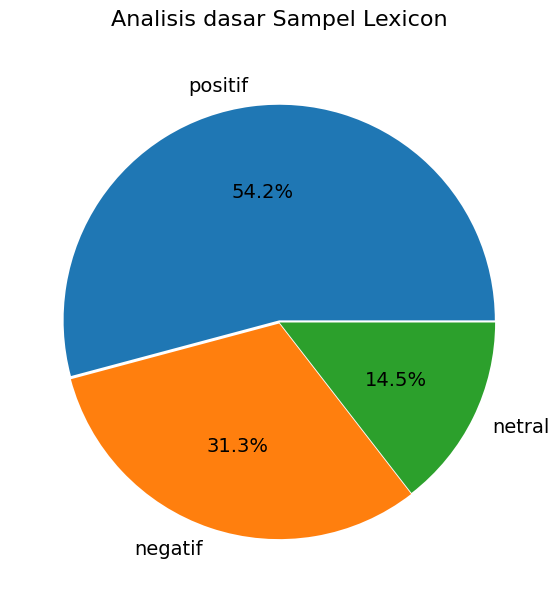

In [144]:
#Inspeksi Pie
fig, ax = plt.subplots(figsize=(7, 7))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in selp]

#pelabelan
labels = list(selp.index)

# Jarak
explode = (0.01, 0.005, 0)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Analisis dasar Sampel Lexicon', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [147]:
#teks sentimen positif

#Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi tweet dengan polaritas netral.
ulasanp = dfkopitungk[dfkopitungk['polaritas'] == 'netral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanz'.
cuitanp = ulasanp[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitanp = cuitanp.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitanp = cuitanp.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitanp.index += 1


In [148]:
#sentimen netral
#Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi tweet dengan polaritas negatif.
ulasanz = dfkopitungk[dfkopitungk['polaritas'] == 'positif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanp'.
cuitanz = ulasanz[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitanz = cuitanz.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitanz = cuitanz.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitanz.index += 1


In [149]:
#teks sentimen negatif

#Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi cuitan dengan polaritas positif.
ulasann = dfkopitungk[dfkopitungk['polaritas'] == 'negatif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanp'.
cuitann = ulasann[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitann = cuitann.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitann = cuitann.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitann.index += 1


#### Visualisasi kata-kata

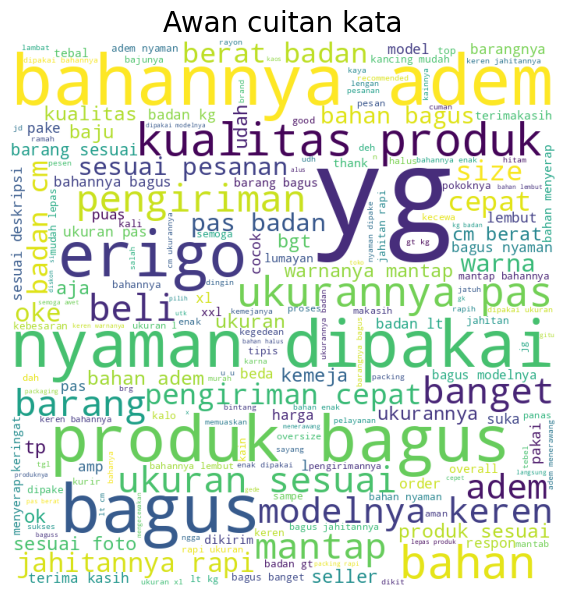

In [150]:
#sentimen di stopword
daftar_kata = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in dfkopitungk['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        daftar_kata += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=8).generate(daftar_kata)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Awan cuitan kata', fontsize=20)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

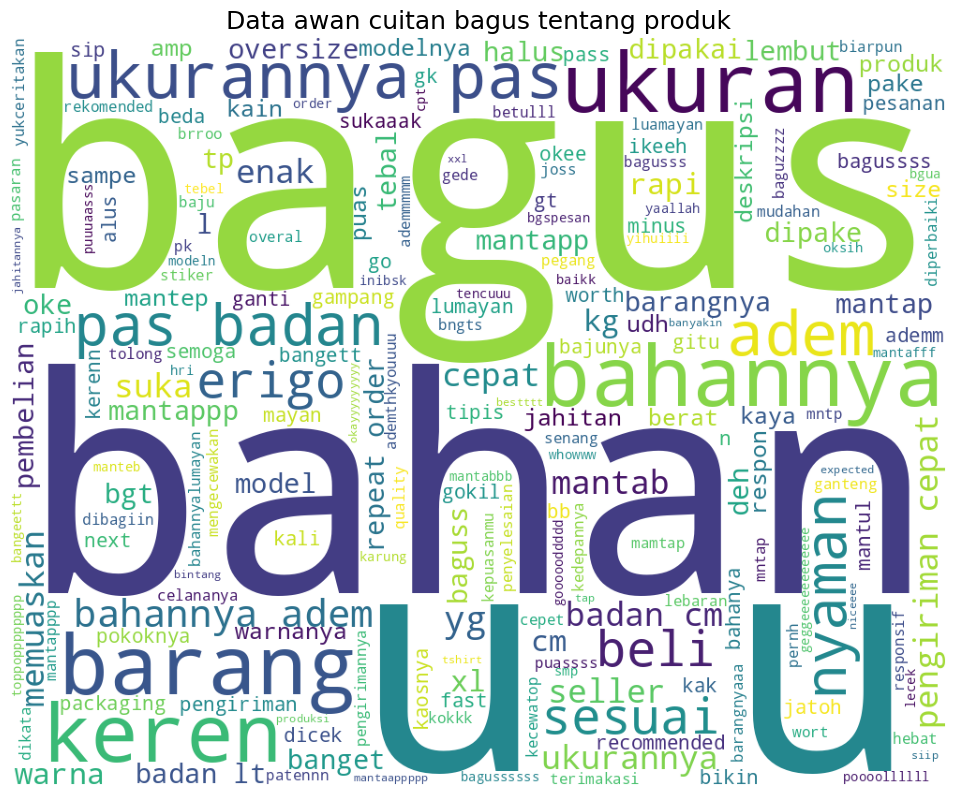

In [151]:
#Cuitan positif
positif = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitanp['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        positif += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=800, background_color='white', min_font_size=10).generate(positif)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(10, 8))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan bagus tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

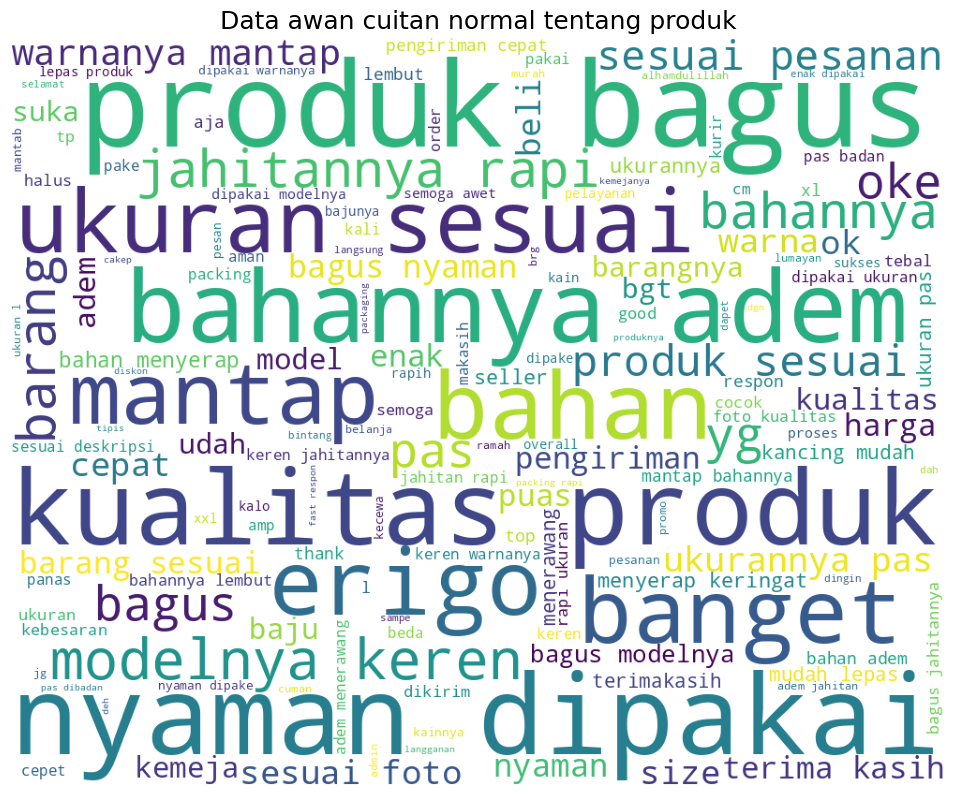

In [161]:
#Cuitan netral
normal = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitanz['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        normal += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=800, background_color='white', min_font_size=10).generate(normal)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(10, 8))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan normal tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

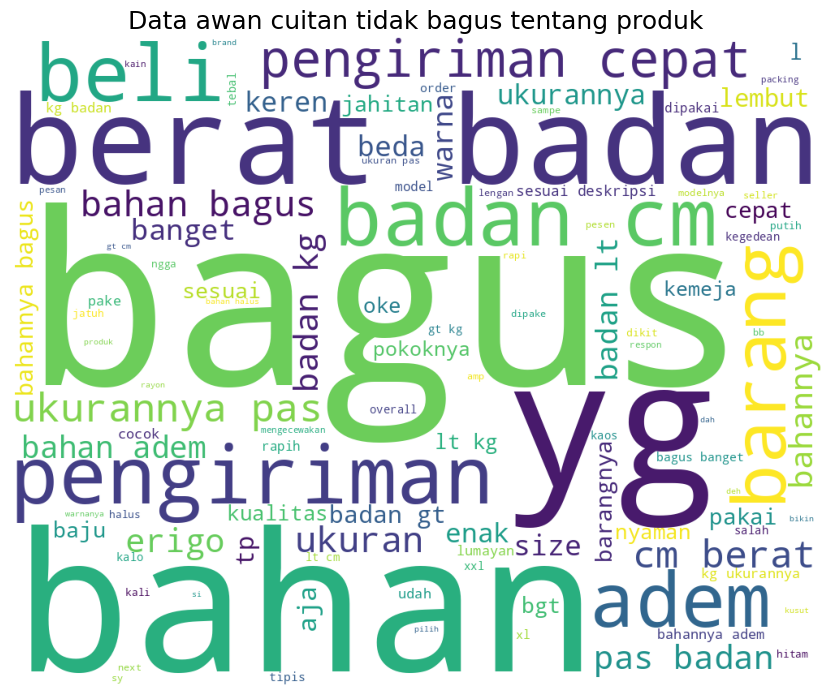

In [162]:
#Cuitan negatif
negatif = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitann['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        negatif += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=800, background_color='white', min_font_size=10).generate(negatif)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(9, 7))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan tidak bagus tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

#### Grafik Batang

In [158]:
#cek kolom
dfkopitungk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1743 entries, 0 to 2202
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Pesan            1743 non-null   object
 1   Nilai            1743 non-null   int64 
 2   Label            1743 non-null   object
 3   bersih           1743 non-null   object
 4   kecil            1743 non-null   object
 5   sopan            1743 non-null   object
 6   token            1743 non-null   object
 7   stopword         1743 non-null   object
 8   final            1743 non-null   object
 9   nilai_polaritas  1743 non-null   int64 
 10  polaritas        1743 non-null   object
dtypes: int64(2), object(9)
memory usage: 163.4+ KB


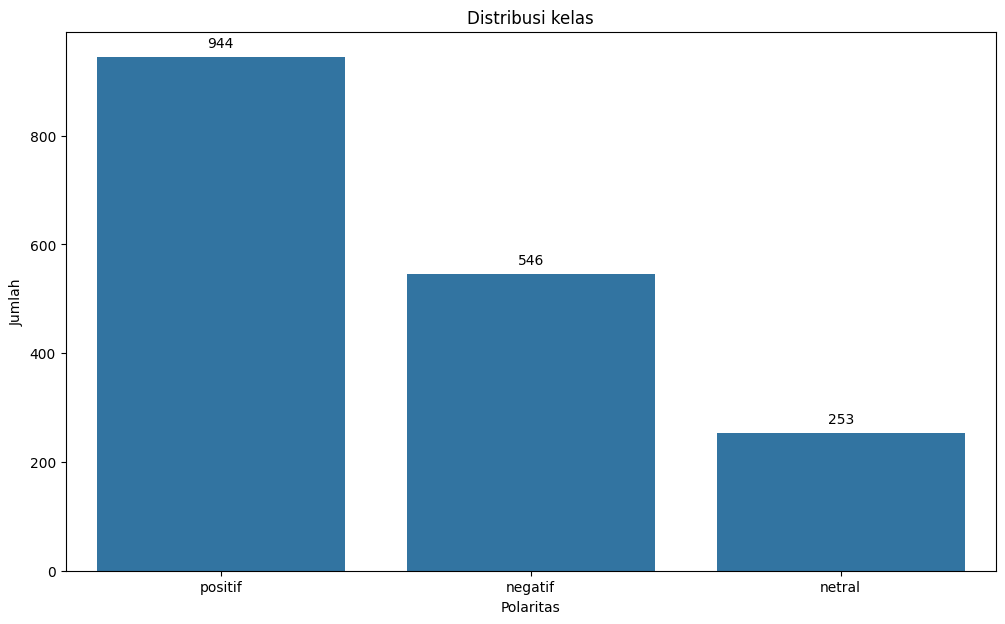

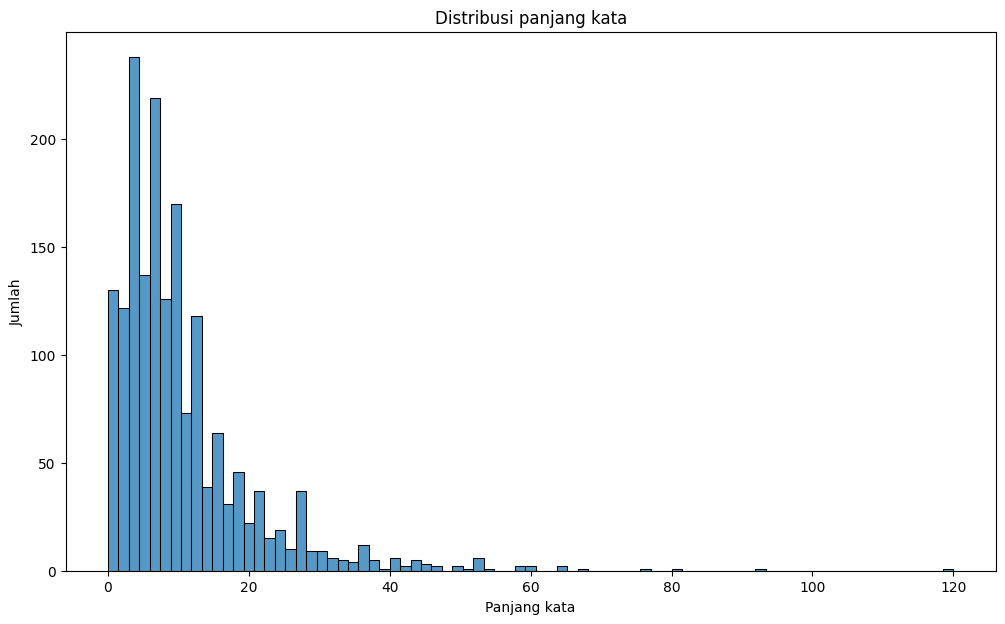

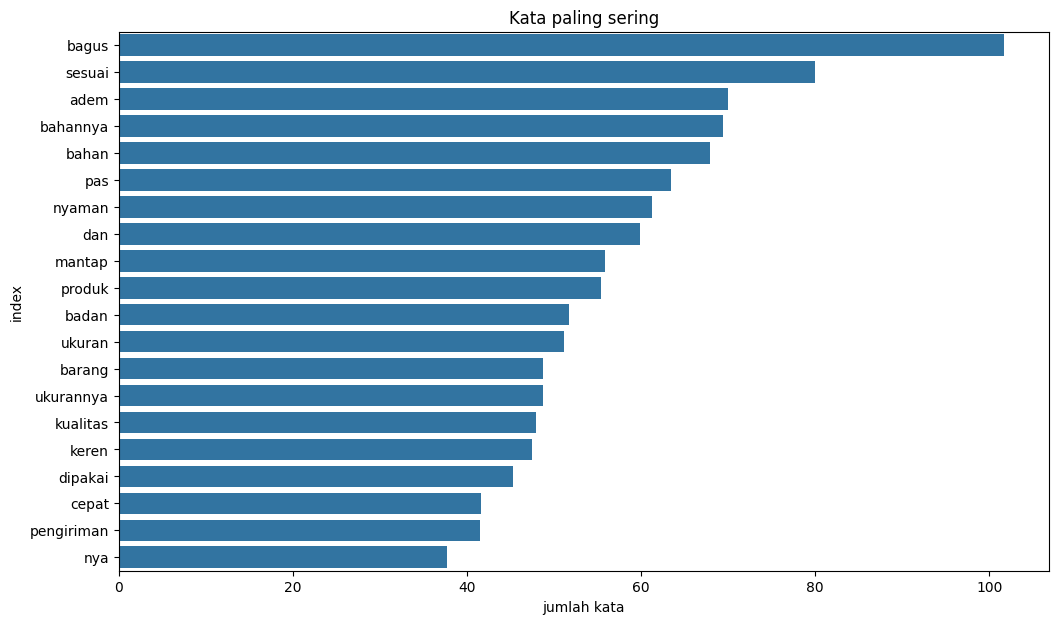

In [159]:
#Grafik batang
# Set the figure size
plt.figure(figsize=(12, 7))

# Check class distribution
class_dist_plot = sns.countplot(x='polaritas', data=dfkopitungk)
plt.title('Distribusi kelas')
plt.xlabel('Polaritas')
plt.ylabel('Jumlah')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Set the figure size
plt.figure(figsize=(12, 7))

# Visualize text length distribution
dfkopitungk['panjang_kata'] = dfkopitungk['final'].apply(lambda x: len(x.split()))
sns.histplot(dfkopitungk['panjang_kata'])
plt.title('Distribusi panjang kata')
plt.xlabel('Panjang kata')
plt.ylabel('Jumlah')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 7))

# Inspeksi kata paling sering
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dfkopitungk['final'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah kata')
tfidf_df = tfidf_df.sort_values('jumlah kata', ascending=False).head(20)
sns.barplot(x='jumlah kata', y='index', data=tfidf_df)
plt.title('Kata paling sering')
plt.show()

#Eksekusi model

In [ ]:
#Teknik RFC (random forest): inisiasi


In [ ]:
#Eksekusi
